# Static Fracture Analysis (SFA) with Python
## ***Instructions to use this notebook***
### 1. Install Anaconda

- Install [anaconda for **Python 3.6**](https://www.anaconda.com/download/) for your OS
- Accept all defaults and add Anaconda to your Path when prompted

### 2. Create environment

It is important to work in a defined environment and to ensure all packages are installed and run in that environement, to that end run the following commands in a terminal, in your working directory for this notebook:

`conda config --add channels conda-forge` This 'channel' will now always be available in your environments

`conda create -n fracs python=3.6` To create an environment called 'fracs' using Python3.6

`conda activate fracs` To activate the 'fracs' environment (which you can leave with `conda deactivate`)

### 3. Install packages to environment

While still in the 'fracs' environment , install the following packages (other packages can be installed later):

`conda install -c conda-forge pandas matplotlib numpy ipython`

`pip install xlrd`

### 4. Enable environment in jupyter notebooks and launch

`python -m ipykernel install --name fracs --display-name "fracs"` To enable the environment

`jupyter notebook` To launch the notebook in a browser

Then create a new notebook using the 'fracs' kernel

### 5. Library imports

In [1]:
# these warning filters are needed for a numpy error
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed") # due a RuntimeWarning with numpy.dtype
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from utils import mdia_to_xyz_minCurve
from mpl_toolkits.mplot3d import Axes3D

### 6. Data import and cleaning

In [2]:
# import data
# well survey
survey = pd.read_csv('../data/HEF_image_interp/for_HEF/Well_Surveys_Projected_to_TD.csv', header=4)
# well tops
tops = pd.read_excel('../data/HEF_image_interp/for_HEF/Well_Formations.xlsx')
# image data
image_data = pd.read_csv('../data/HEF_image_interp/ASCII_n_LAS/well_1D_all.txt',skiprows=(1,2))

In [3]:
# clean up survey
# drop NaN
survey_edt = survey.dropna(how='all')
survey_edt = survey_edt.dropna(axis='columns', how='all')
survey_edt.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Vertical Section[m]
0,0,0.0,0.00,0.00,0.00,0.00,NaN,0.00
1,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.26
2,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.41
3,134,0.9,15.59,133.99,1.47,0.30,0.03,0.53
4,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.72


In [4]:
survey_edt.tail(2)

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Vertical Section[m]
79,2267.00,35.43,298.39,2013.3,498.84,-797.35,0.29,940.51
82,All data is in Metres unless otherwise stated\...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Copy survey information from survey dataframe and save to seperate dataframe
survey_info = survey_edt[-1:]
survey_info = survey_info.drop(columns=list(survey_edt)[1:],inplace=False)
survey_info.rename(index=str, columns={"MD[m]": "Survey Info"}, inplace=True)
survey_info.reset_index(inplace=True, drop=True)
survey_info

,Survey Info
0,All data is in Metres unless otherwise stated\...


In [6]:
# Delete Survey information from survey dataframe
survey_edt = survey_edt[:-1]
survey_edt.tail()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Vertical Section[m]
75,2171.08,35.90,298.69,1935.50,472.03,-748.06,0.33,884.53
76,2199.36,36.00,298.69,1958.40,480.00,-762.62,0.11,901.10
77,2228.15,35.80,298.39,1981.72,488.07,-777.45,0.28,917.10
78,2248.73,35.80,298.49,1998.43,493.79,-788.01,0.30,929.93
79,2267.00,35.43,298.39,2013.30,498.84,-797.35,0.29,940.51


In [7]:
# convert data to floats
survey_edt = survey_edt.apply(pd.to_numeric)

In [8]:
tops.head(3)

,DD-11 Formations,Unnamed: 1,Unnamed: 2,Unnamed: 3,YMT Comments
0,MD,TVD,Formations,Log Tops,Remarks
1,5.5,5.5,Lower Bakhtiari,5.5,No Gamma
2,445,441.37,Upper Fars,445,No Gamma


In [9]:
# Clean up tops
tops.columns = tops.iloc[0]
tops.drop(columns=['Log Tops', 'Remarks'], inplace=True)
tops.drop([0], inplace=True)
tops.reset_index(inplace=True, drop=True)
tops = tops.apply(pd.to_numeric, errors='ignore')
tops

,MD,TVD,Formations
0,5.50,5.50,Lower Bakhtiari
1,445.00,441.37,Upper Fars
2,810.00,770.91,Lower Fars
3,1150.00,1065.27,Pila Spi
4,1318.00,1210.50,Gercus
5,1372.00,1257.41,Sinjar
6,1495.00,1364.37,Kolosh
7,1885.00,1699.87,Shiranish
8,2032.00,1822.94,Kometan
9,2049.01,1836.73,Upper Qamchuqa


In [10]:
image_data.head()

,#DEPTH DIP AZIM QUAL DEVI HAZI AAZI ADIP DIPTYPE
0,1886.85 5.5 321.8 1.00 30.9 262.4 27...
1,1887.40 12.9 329.4 1.00 30.8 257.0 27...
2,1887.97 6.7 326.7 1.00 30.9 255.0 26...
3,1888.53 10.5 320.5 1.00 30.8 263.3 27...
4,1889.34 6.7 336.3 1.00 30.8 298.0 30...


In [11]:
headers = image_data.columns.values

In [12]:
headers = headers[0].split()
headers

['#DEPTH', 'DIP', 'AZIM', 'QUAL', 'DEVI', 'HAZI', 'AAZI', 'ADIP', 'DIPTYPE']

In [13]:
image_data = image_data['#DEPTH  DIP    AZIM   QUAL   DEVI   HAZI   AAZI   ADIP      DIPTYPE'].str.split(n=None,expand=True)

In [14]:
image_data.head()

,0,1,2,3,4,5,6,7,8,9
0,1886.85,5.5,321.8,1.00,30.9,262.4,270.8,34.0,BED,None
1,1887.40,12.9,329.4,1.00,30.8,257.0,277.8,36.6,BED,None
2,1887.97,6.7,326.7,1.00,30.9,255.0,266.5,33.5,BED,None
3,1888.53,10.5,320.5,1.00,30.8,263.3,277.8,37.4,BED,None
4,1889.34,6.7,336.3,1.00,30.8,298.0,305.0,36.3,BED,None


In [15]:
image_data.fillna(value='',inplace=True)
image_data.head()

,0,1,2,3,4,5,6,7,8,9
0,1886.85,5.5,321.8,1.00,30.9,262.4,270.8,34.0,BED,
1,1887.40,12.9,329.4,1.00,30.8,257.0,277.8,36.6,BED,
2,1887.97,6.7,326.7,1.00,30.9,255.0,266.5,33.5,BED,
3,1888.53,10.5,320.5,1.00,30.8,263.3,277.8,37.4,BED,
4,1889.34,6.7,336.3,1.00,30.8,298.0,305.0,36.3,BED,


In [16]:
image_data[8] = image_data[8] + image_data[9]
image_data.drop(columns=[9], inplace=True)
image_data.columns = headers
image_data = image_data.apply(pd.to_numeric, errors='ignore')
image_data.head()

,#DEPTH,DIP,AZIM,QUAL,DEVI,HAZI,AAZI,ADIP,DIPTYPE
0,1886.85,5.5,321.8,1.0,30.9,262.4,270.8,34.0,BED
1,1887.40,12.9,329.4,1.0,30.8,257.0,277.8,36.6,BED
2,1887.97,6.7,326.7,1.0,30.9,255.0,266.5,33.5,BED
3,1888.53,10.5,320.5,1.0,30.8,263.3,277.8,37.4,BED
4,1889.34,6.7,336.3,1.0,30.8,298.0,305.0,36.3,BED


### 7. Cleaned data export for backup

In [17]:
# export cleaned data to csv
survey_edt.to_csv('../data/cleanedData/survey_edt.csv',sep=',')
survey_info.to_csv('../data/cleanedData/survey_info.csv',sep=',')
tops.to_csv('../data/cleanedData/tops.csv',sep=',')
image_data.to_csv('../data/cleanedData/image_data.csv',sep=',')

### 8. Exploratory data analysis

In [18]:
#survey_edt, survey_info, tops, image_data
survey_edt.head()

,MD[m],Inc[deg],Azi[deg],TVD[m],North[m],East[m],Dogleg [deg/30m],Vertical Section[m]
0,0.00,0.0,0.00,0.00,0.00,0.00,NaN,0.00
1,76.29,0.9,7.19,76.29,0.59,0.07,0.35,0.26
2,104.36,0.9,17.20,104.35,1.02,0.17,0.17,0.41
3,134.00,0.9,15.59,133.99,1.47,0.30,0.03,0.53
4,162.73,1.1,6.39,162.72,1.96,0.39,0.27,0.72


In [19]:
survey_info['Survey Info'][0]

"All data is in Metres unless otherwise stated\r\nCoordinates are from Installation MD's are from Rig and TVD's are from Rig ( Actual Datum #1 430.1m above Mean Sea Level )\r\nVertical Section is from 0.00N 0.00E on azimuth 302.380 degrees\r\nBottom hole distance is 901.11 Metres on azimuth 302.19 degrees from Wellhead\r\nCalculation method uses Minimum Curvature method"

In [25]:
# get xyz arrays for survey
x_dev = mdia_to_xyz_minCurve('../data/cleanedData/survey_edt.csv')[0]
y_dev = mdia_to_xyz_minCurve('../data/cleanedData/survey_edt.csv')[1]
z_dev = mdia_to_xyz_minCurve('../data/cleanedData/survey_edt.csv')[2]

In [53]:
x_pos = []
y_pos = []
z_pos = []
temp_pos = 0
for line in x_dev:
    temp_pos += line
    x_pos.append(temp_pos)
    
temp_pos = 0
for line in y_dev:
    temp_pos += line
    y_pos.append(temp_pos)

temp_pos = 0
for line in z_dev:
    temp_pos += line
    z_pos.append(-1 * temp_pos)
    


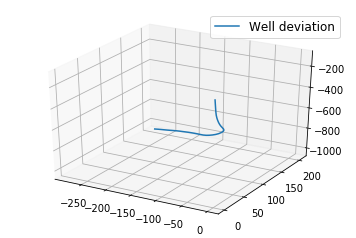

In [54]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')


mpl.rcParams['legend.fontsize'] = 12

fig = plt.figure()
ax = fig.gca(projection='3d')
#theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
z = z_pos
#r = z**2 + 1
x = x_pos
y = y_pos
ax.plot(x, y, z, label='Well deviation')
ax.legend()

plt.show()

### 9. Static Fracture Analysis

<hr>

![agile_logo](agile_logo_size_50.jpg)
<p style="text-align:center;color:gray">© Agile Geoscience 2018. Licensed CC-BY.</p>
</hr>